In [1]:
%matplotlib inline

In [26]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm

import corner
# Adjust default font size so that labels are readable in plots
font = {'size': 16}
mpl.rc('font', **font)

In [3]:
import astropy.table

#tab = astropy.table.Table.read('../data/sub_fit/subfit_new.txt', format='ascii')
#tab = astropy.table.Table.read('../data/sub_fit/subfit_new_pserr_npadded_handfix.txt', format='ascii')
tab = astropy.table.Table.read('../data/newsub_panel_fit_results_mc.txt', format='ascii')
print(tab)

panel_ID  Np mh_cutl mh_cuth zcut_l ... sd_bg_best esd_h  esd_bg rchi_sqr
-------- --- ------- ------- ------ ... ---------- ------ ------ --------
       1   5    10.0    11.1  0.012 ...     364.53 18.768 35.678    0.663
       2  52    10.0    11.1  0.072 ...    163.268  2.554  6.318    0.398
       3  40    10.2    11.1   0.13 ...    101.939  2.004  3.574     1.96
       4  62    10.3    11.1  0.165 ...     78.275  1.409  2.137     0.66
       5  54    10.5    11.1   0.21 ...     69.478  2.001  2.493    1.133
       6  11    11.1    11.6  0.012 ...    366.507  7.853 24.122    1.172
       7 104    11.1    11.6  0.072 ...    157.843  1.399  3.017    0.015
       8  51    11.1    11.6   0.13 ...    111.364  1.685  3.333    0.602
       9  97    11.1    11.6  0.165 ...     88.936   1.19  1.686    0.537
      10 153    11.1    11.6   0.21 ...     69.943   0.74  1.149    0.245
      11  40    11.6    12.3  0.072 ...    170.311  1.916    4.6    0.706
      12  14    11.6    12.3   0.13 ..

In [4]:
#define some columns that will be used for fitting

p_id = tab['panel_ID']
n_p  = tab['Np']
mh_cutl = tab['mh_cutl']
mh_cuth = tab['mh_cuth']
zcut_l  = tab['zcut_l'] 
zcut_h  = tab['zcut_h']
mh_sub  = tab['mh_mean']
emh_sub = tab['mh_err']
z_sub   = tab['z_mean'] 
ez_sub  = tab['z_err']
da2_sub = tab['dA2_mean']
eda2_sub= tab['dA2_err']
sd_halo = tab['sd_h_best']
sd_bg   = tab['sd_bg_best']
esd_halo= tab['esd_h']
esd_bg  = tab['esd_bg'] 
rchi_sqr= tab['rchi_sqr']


#graph setting:
mpl.rcParams["errorbar.capsize"] =5

We assume a linear relation of $\log M$ and $\log \Sigma_{\rm halo}$, or say a power law relation between mass and satellite surface number density. 
$$
\log \Sigma_{\rm halo} = a \log \frac{M_h}{10^{12} M_\odot} +b
$$
or say
$$
\Sigma_{\rm halo} = 10^b \left( \frac{M_h}{10^{12} M_\odot} \right)^a 
$$

In [5]:
def model(paras, x):
    a,b = paras
    return 10.0**(b + a *(x-12.))

def lnlike(data, e_data, x, paras):
    return -0.5* np.sum( (model(paras, x)-data)**2 / e_data**2 )

def lnprior(paras):
    a,b = paras
    non_eff = a<-0.4
    return -9999.9*non_eff

def mc_sampling(data, e_data, x, n_chain, paras_0=[0.5, 0.5]):
    n_burn = int(n_chain/9)
    
    a_current, b_current = np.copy(paras_0)
    #initialize the chain storage
    a_chain = [a_current]
    b_chain = [b_current]
    #initiallize the accept history of a and b
    a_accept_chain = [1]
    b_accept_chain = [1]
    
    #lnlike_chain=[]
    
    lnlike_current = lnlike(data, e_data, x, [a_current, b_current])
    lnprior_current= lnprior([a_current, b_current])
    lnlike_chain = [lnlike_current +lnprior_current]
    
    #set intial step length
    step_a, step_b = [0.3, 0.3]
    for i in range(n_chain):
        
        a_proposal = norm(a_current, step_a).rvs()
        b_proposal = norm(b_current, step_b).rvs()
        
        lnlike_proposal_a  = lnlike(data, e_data, x, [a_proposal, b_current])
        lnprior_proposal_a = lnprior([a_proposal, b_current])
        
        lnlike_proposal_b  = lnlike(data, e_data, x, [a_current, b_proposal])
        lnprior_proposal_b = lnprior([a_current, b_proposal])
        
        paccept_a = np.exp(max(lnlike_proposal_a  +lnprior_proposal_a -lnlike_current-lnprior_current
                                  , -799.9))
        paccept_b = np.exp(max(lnlike_proposal_b  +lnprior_proposal_b -lnlike_current-lnprior_current
                                  , -799.9))
        #judge if accept:
        accept_a  = np.random.rand() <paccept_a
        accept_b  = np.random.rand() <paccept_b
        #update current value
        a_current += accept_a *(a_proposal-a_current)
        b_current += accept_b *(b_proposal-b_current)
        #update the steplength
        step_a += step_a*0.05*accept_a -(1-accept_a)*step_a*0.05
        step_b += step_b*0.05*accept_b -(1-accept_b)*step_b*0.05
        
        #check new likelyhood for the next loop also for output
        lnlike_current = lnlike(data, e_data, x, [a_current, b_current])
        lnprior_current= lnprior([a_current, b_current])
        
        #record the chain value for the three parameters
        a_chain.append(a_current)
        b_chain.append(b_current)
        
        #record the likelihood chain
        lnlike_chain.append(lnlike_current+lnprior_current)
        
        #record the accept history of the three parameters
        a_accept_chain.append(accept_a)
        b_accept_chain.append(accept_b)
        
    AR_burn_a = sum(a_accept_chain[:n_burn])/float(n_burn)
    AR_burn_b = sum(b_accept_chain[:n_burn])/float(n_burn)
    AR_chain_a = sum(a_accept_chain[n_burn:])/float(n_chain-n_burn+1)
    AR_chain_b = sum(b_accept_chain[n_burn:])/float(n_chain-n_burn+1)
    print('The burn in accept rate for [a,b] is:  ', AR_burn_a, AR_burn_b)
    print('The chain part accept rate for [a,b] is:', AR_chain_a, AR_chain_b)
    
    return a_chain, b_chain, lnlike_chain

def plt_chain(paras_chain):
    n_paras = len(para_chain[:,0])
        
    
def plot_fit_20vs_combos(data, e_data, x, a_chain, b_chain, lnlike_chain):
    #plt.plot(x, data, 'ro')
    plt.figure(figsize=(13, 10))
    plt.subplot(221)
    plt.errorbar(x, data, yerr=e_data, xerr=emh_sub, fmt='ro',label='sub results')
    plt.xlabel(r'$\log (M_h / M_*)$', fontsize=14)
    plt.ylabel(r'Surface Density / Mpc$^-2$', fontsize=14)
    
    lct_best = np.argmax(lnlike_chain)
    a_best= a_chain[lct_best]
    b_best= b_chain[lct_best]
    x_model = np.arange(9.5, 13.8, 0.05)
    #y_model = model([np.median(a_chain), np.median(b_chain)], x_model)
    y_model = model([a_best, b_best], x_model)
    #y_pred  = model([np.median(a_chain), np.median(b_chain)], x)
    y_pred  = model([a_best, b_best], x)
    chi2_r_0 = np.sum((y_pred-data)**2/ e_data**2)/(len(x)-2)
    #print('The best model parameters: a=', np.mean(a_chain), ' b=', np.mean(b_chain))
    print('The best model parameters: a=', a_best, ' b=', b_best)
    plt.plot(x_model, y_model, label=r'Fit, Reduced $\chi^2 =$ %6.3f' %chi2_r_0)
    std_y_model = []
    for xi in x_model:
        yi = 10.0**(b_chain + a_chain *(xi-12.))
        std_yi = np.std(yi, ddof=1)
        std_y_model.append(std_yi)
    plt.fill_between(x_model, y_model+std_y_model, y_model-std_y_model, color='orange')
    plt.legend(fontsize=11, loc=2)
    
    plt.subplot(222)
    plt.title('Binning up close points')
    xcombo = []
    dcombo = []
    yerrcombo = []
    inverse_sqv = 1./ esd_halo**2
    x_bin_bd = [9.0,11.,11.5,12.0, 12.7, 14.0 ]
    for i in range(5):
        sub_i = (x>x_bin_bd[i]) * (x<x_bin_bd[i+1])
        sum_invar = np.sum(inverse_sqv[sub_i])
        xcombo.append(  sum(x[sub_i]* inverse_sqv[sub_i])  /sum_invar)
        dcombo.append(  sum(data[sub_i]* inverse_sqv[sub_i]) /sum_invar)
        yerrcombo.append( np.sqrt(1. /np.sum(inverse_sqv[sub_i])))
    print('the combined x_s:', xcombo)
    print('the combined y:', dcombo)
    
    #ycombo_model = model([np.median(a_chain), np.median(b_chain)],np.array(xcombo))
    ycombo_model = model([a_best, b_best],np.array(xcombo))
    chi2_combo = np.sum((np.array(dcombo)-ycombo_model)**2 / np.array(yerrcombo)**2)
    chi2_r_combo = chi2_combo/3.
    
    ycombo_test = ycombo_model*1.05
    chi2_r_combo_test = np.sum((np.array(dcombo)-ycombo_test)**2 / np.array(yerrcombo)**2) /3.0
    plt.errorbar(xcombo, dcombo, yerr=yerrcombo, fmt='ro')
    plt.plot(x_model, y_model, label=r'Reduced $\chi^2 =$ %6.3f' % chi2_r_combo)
    plt.plot(x_model, y_model*1.05, label=r'(Test) reduced $\chi^2 =$ %6.3f' %chi2_r_combo_test)
    plt.fill_between(x_model, y_model+std_y_model, y_model-std_y_model, color='orange')
    plt.xlabel(r'$\log (M_h / M_*)$', fontsize=14)
    plt.ylabel(r'Surface Density / Mpc$^-2$', fontsize=14)
    plt.legend(fontsize=11)
    
    plt.show()
    


In [6]:
## Fitting
cut = mh_sub >9
data = sd_halo[cut]
e_data = esd_halo[cut]
x_input = mh_sub[cut]
a_mc, b_mc, lnlike_mc = mc_sampling(data,e_data,x_input, 15500)


The burn in accept rate for [a,b] is:   0.5075493612078978 0.508130081300813
The chain part accept rate for [a,b] is: 0.5125190507293708 0.5123739023151173


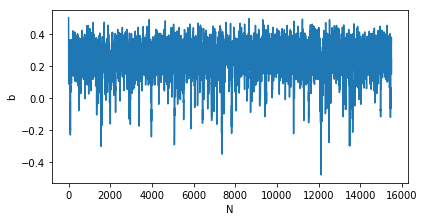

In [7]:
plt.figure(figsize=(14, 7))

plt.plot(a_mc)
plt.xlabel('N')
plt.ylabel('a')

plt.subplot(222)
plt.plot(b_mc)
plt.xlabel('N')
plt.ylabel('b')
plt.show()

The best model parameters: a= 0.28348773876890165  b= 0.2923474662253047
the combined x_s: [10.933621788514863, 11.339770404891155, 11.838744450875309, 12.571038549869598, 13.191939221673605]
the combined y: [-0.3702465581916161, 1.2463209974310583, 2.442314802033776, 2.810524088515132, 4.10813595511351]


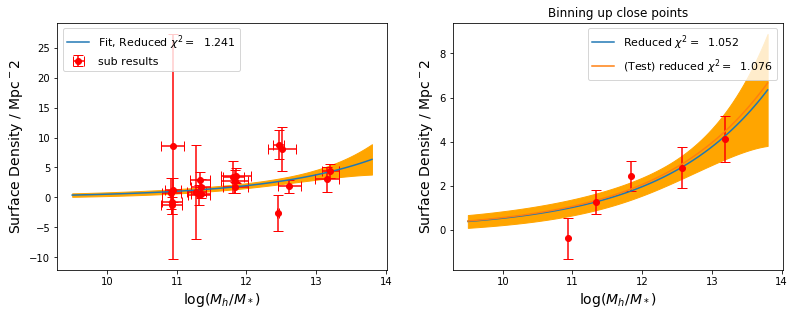

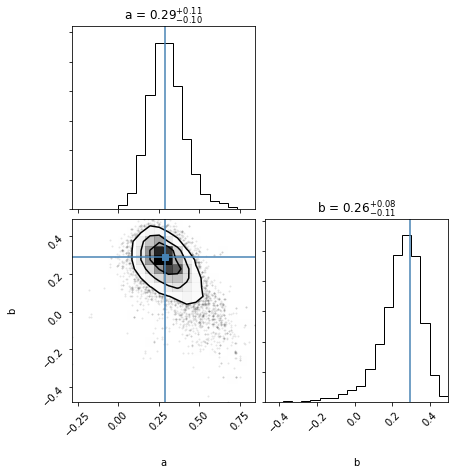

In [8]:
#plot_fit(sd_halo, 0.5*(sd_halo_u-sd_halo_l), mh_sub, [np.mean(a_mc), np.mean(b_mc)])
N_burn = 2200
plot_fit_20vs_combos(sd_halo, esd_halo, mh_sub, np.array(a_mc[N_burn:]), 
                    np.array(b_mc[N_burn:]), np.array(lnlike_mc[N_burn:]))



lct_best = np.argmax(lnlike_mc)
a_best= a_mc[lct_best]
b_best= b_mc[lct_best]
    
fig = corner.corner(np.vstack([a_mc[N_burn:], b_mc[N_burn:]]).T, 
                    labels=['a', 'b'],
                    truths=[a_best, b_best],
                    show_titles=True)
fig.set_size_inches(7,7)


The best model parameters: a= 0.28348773876890165  b= 0.2923474662253047


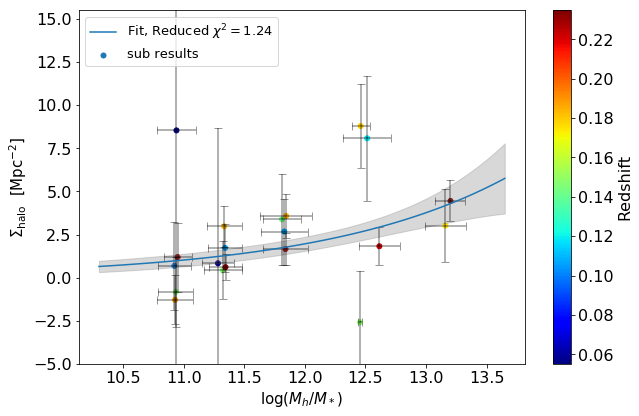

<Figure size 600x400 with 0 Axes>

In [27]:
mpl.rcParams["errorbar.capsize"] =4
def plot_fit(data, e_data, x, a_chain, b_chain, lnlike_chain,colors=[]):
    
    plt.figure(figsize=(10, 6.5))
    plt.errorbar(x, data, yerr=e_data, xerr=emh_sub,alpha=0.4,fmt=',',color='k',label='')
    plt.scatter(x, data, s=25,c=colors,cmap='jet',label='sub results')
    plt.colorbar(label='Redshift')
    
    plt.xlabel(r'$\log (M_h / M_*)$', fontsize=15)
    plt.ylabel(r'$\Sigma_{\rm halo}$  [Mpc$^{-2}$]', fontsize=15)
    plt.ylim([-5,15.5])
    
    lct_best = np.argmax(lnlike_chain)
    a_best= a_chain[lct_best]
    b_best= b_chain[lct_best]
    x_model = np.arange(10.3, 13.7, 0.05)
    #y_model = model([np.median(a_chain), np.median(b_chain)], x_model)
    y_model = model([a_best, b_best], x_model)
    #y_pred  = model([np.median(a_chain), np.median(b_chain)], x)
    y_pred  = model([a_best, b_best], x)
    chi2_r_0 = np.sum((y_pred-data)**2/ e_data**2)/(len(x)-2)
    #print('The best model parameters: a=', np.mean(a_chain), ' b=', np.mean(b_chain))
    print('The best model parameters: a=', a_best, ' b=', b_best)
    plt.plot(x_model, y_model, label=r'Fit, Reduced $\chi^2 =$%4.2f' %chi2_r_0)
    std_y_model = []
    for xi in x_model:
        yi = 10.0**(b_chain + a_chain *(xi-12.))
        std_yi = np.std(yi, ddof=1)
        std_y_model.append(std_yi)
    plt.fill_between(x_model, y_model+std_y_model, y_model-std_y_model, color='grey', alpha=0.3)
    plt.legend(fontsize=13, loc=2)
    plt.show()
    
plot_fit(sd_halo, esd_halo, mh_sub, np.array(a_mc[N_burn:]), 
            np.array(b_mc[N_burn:]), np.array(lnlike_mc[N_burn:]),
            colors=z_sub)
plt.savefig('fit_shalo_mh.png',dpi=250)

## If we fit with the combined points (with inverse-variance weighting)

From the test above, we can see the best fit for all point is not the best fit for the case where we binned up close point with inverse-variance weighting. 

So let's try refit it with the combined points. 


In [10]:
def combine_points(x, sd_halo, esd_halo):
    xcombo = []
    dcombo = []
    yerrcombo = []
    inverse_sqv = 1./ esd_halo**2
    x_bin_bd = [9.0,11.1,11.55,12.0, 12.7, 14.0 ]
    for i in range(5):
        sub_i = (x>x_bin_bd[i]) * (x<x_bin_bd[i+1])
        sum_invar = np.sum(inverse_sqv[sub_i])
        xcombo.append(  sum(x[sub_i]* inverse_sqv[sub_i])  /sum_invar)
        dcombo.append(  sum(data[sub_i]* inverse_sqv[sub_i]) /sum_invar)
        yerrcombo.append( np.sqrt(1. /np.sum(inverse_sqv[sub_i])))
    #print('the combined x_s:', xcombo)
    #print('the combined y:', dcombo)
    return np.array(xcombo), np.array(dcombo), np.array(yerrcombo)

x_combo, sd_combo, esd_combo = combine_points(mh_sub, sd_halo, esd_halo)
print('the combined x_s:', x_combo)
print('the combined y:', sd_combo)

the combined x_s: [10.93362179 11.3397704  11.83874445 12.57103855 13.19193922]
the combined y: [-0.37024656  1.246321    2.4423148   2.81052409  4.10813596]


In [28]:
### check what if we only looking at the lower redshift ones
def combine_lowz(x, sd_halo, esd_halo, z_sub):
    xcb_lz =[]
    dcb_lz = []
    yerr_cb = []
    inverse_sqv = 1./ esd_halo**2
    x_bin_bd = [9.0,11.1,11.55,12.0, 12.7 ]
    for i in range(4):
        sub_i = (x>x_bin_bd[i]) * (x<x_bin_bd[i+1]) *(z_sub < 0.17)
        sum_invar = np.sum(inverse_sqv[sub_i])
        xcb_lz.append(  sum(x[sub_i]* inverse_sqv[sub_i])  /sum_invar)
        dcb_lz.append(  sum(data[sub_i]* inverse_sqv[sub_i]) /sum_invar)
        yerr_cb.append( np.sqrt(1. /np.sum(inverse_sqv[sub_i])))
    #print('the combined x_s:', xcombo)
    #print('the combined y:', dcombo)
    return np.array(xcb_lz), np.array(dcb_lz), np.array(yerr_cb)

xcombo_lz, sdcombo_lz, esdcombo_lz = combine_lowz(mh_sub, sd_halo, esd_halo, z_sub)
print('the combined x_s:', xcombo_lz)
print('the combined y:', sdcombo_lz)

the combined x_s: [10.93001661 11.33330316 11.8237162  12.47928256]
the combined y: [-0.19228902  1.18417534  2.91588714  1.76023089]


In [12]:
a_mc_combo, b_mc_combo, lnlike_mc_combo = mc_sampling(sd_combo,esd_combo,x_combo, 12600)

The burn in accept rate for [a,b] is:   0.5071428571428571 0.5057142857142857
The chain part accept rate for [a,b] is: 0.512811356128917 0.5129006338719757


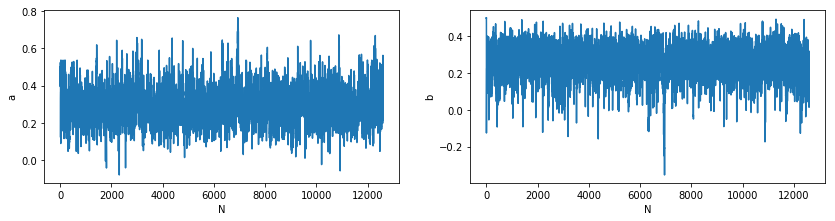

In [13]:
plt.figure(figsize=(14, 7))
plt.subplot(221)
plt.plot(a_mc_combo)
plt.xlabel('N')
plt.ylabel('a')

plt.subplot(222)
plt.plot(b_mc_combo)
plt.xlabel('N')
plt.ylabel('b')
plt.show()

The best model parameters: a= 0.2906423324094096  b= 0.2931275481579938


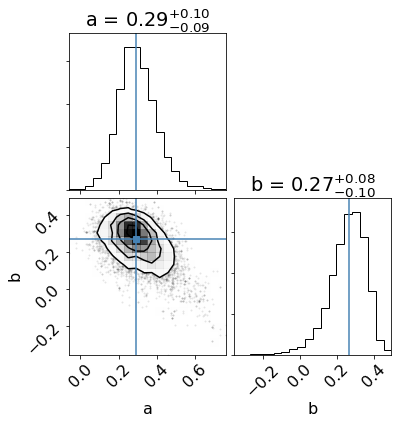

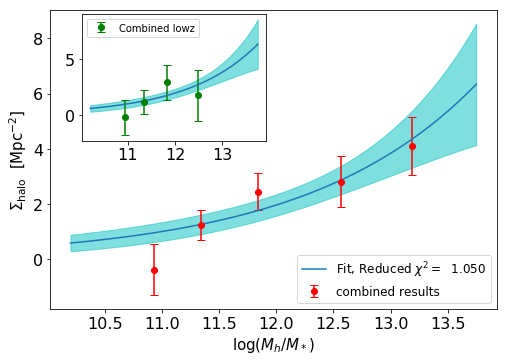

<Figure size 600x400 with 0 Axes>

In [38]:
def plt_sd_combo(data, e_data, x, a_chain, b_chain, lnlike_chain, 
                 xcombo_lz=xcombo_lz, sdcombo_lz=sdcombo_lz, esdcombo_lz=esdcombo_lz):
    plt.figure(figsize=(8, 5.5))
    plt.errorbar(x, data, yerr=e_data, fmt='ro',label='combined results')
    plt.xlabel(r'$\log (M_h / M_*)$', fontsize=15)
    plt.ylabel(r'$\Sigma_{\rm halo}$  [Mpc$^{-2}$]', fontsize=15)
    lct_best = np.argmax(lnlike_chain)
    a_best= a_chain[lct_best]
    b_best= b_chain[lct_best]
    x_model = np.arange(10.2, 13.75, 0.05)
    #y_model = model([np.median(a_chain), np.median(b_chain)], x_model)
    y_model = model([a_best, b_best], x_model)
    #y_pred  = model([np.median(a_chain), np.median(b_chain)], x)
    y_pred  = model([a_best, b_best], x)
    chi2_r_0 = np.sum((y_pred-data)**2/ e_data**2)/(len(x)-2)
    print('The best model parameters: a=', a_best, ' b=', b_best)
    plt.plot(x_model, y_model, label=r'Fit, Reduced $\chi^2 =$ %6.3f' %chi2_r_0)
    std_y_model = []
    for xi in x_model:
        yi = 10.0**(b_chain + a_chain *(xi-12.))
        std_yi = np.std(yi, ddof=1)
        std_y_model.append(std_yi)
    plt.fill_between(x_model, y_model+std_y_model, y_model-std_y_model, color='c',alpha=0.5)
    plt.legend(fontsize=12, loc=4)
    
    #add the lowz combo points
    ax2 = plt.axes([0.18, 0.55, 0.32,0.32])
    plt.errorbar(xcombo_lz, sdcombo_lz, yerr=esdcombo_lz, fmt='go', label='Combined lowz')
    plt.plot(x_model, y_model)
    plt.fill_between(x_model, y_model+std_y_model, y_model-std_y_model, color='c',alpha=0.5)
    plt.legend(fontsize=10, loc=2)
    plt.show()
    
N_burn = 3000
#fig, axs = plt.subplots(1,2)

fig=corner.corner(np.vstack([a_mc_combo[N_burn:], b_mc_combo[N_burn:]]).T, 
                    truths=[np.median(a_mc_combo[N_burn:]), np.median(b_mc_combo[N_burn:])],
                    labels=['a', 'b'],
                    show_titles=True)
fig.set_size_inches(6,6)

plt_sd_combo(sd_combo, esd_combo, x_combo, 
             np.array(a_mc_combo[N_burn:]), np.array(b_mc_combo[N_burn:]), np.array(lnlike_mc_combo[N_burn:]))
plt.savefig('fit_shalo_mh_combo.png',dpi=300)

In [15]:
# output the chain (post burn-in) values:
from astropy.table import Column
from astropy.table import Table
from astropy.io import ascii

ochain_a = Column(a_mc[N_burn:], name='Chain_a', dtype=float,format='%10.4f')
ochain_b = Column(b_mc[N_burn:], name='Chain_b', dtype=float,format='%10.4f')

tab_ochain_ab = Table([ochain_a, ochain_b])
fout_ochain_ab = '../data/newsub_panel_pfit_chainvalues_ab.txt'
ascii.write(tab_ochain_ab, fout_ochain_ab)

# Fitting the background component

Model

In [16]:
#graph setting:
mpl.rcParams["errorbar.capsize"] =2

def plt_sdbg_da2(da2, eda2, sd_bg, esd_bg, mh):
    fig, ax = plt.subplots(figsize=[9,5])
    plt.errorbar(da2, sd_bg, xerr=eda2, yerr=esd_bg, fmt='.', color='black', alpha=0.5)
    plt.scatter(da2, sd_bg, s=40,c=mh,alpha=0.9,cmap='jet')
    plt.xlabel(r'd$_A^{-2}$')
    plt.ylabel(r'$\Sigma_{\rm bg}$ (Mpc$^{-2}$)')
    plt.loglog()
    plt.colorbar(label=r'$M_h$')

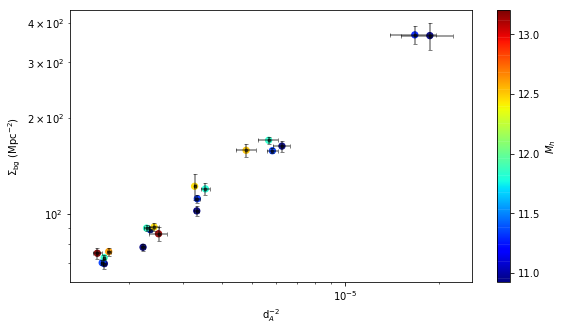

In [17]:
plt_sdbg_da2(da2_sub, eda2_sub, sd_bg, esd_bg, mh_sub)

In [18]:
def lnlike_bg(params, da2, sd_bg, esd_bg):
    intcept, slope = params['Int'], params['Slope']
    model = intcept + slope* (da2-2.0)
    return -0.5* np.sum((sd_bg-model)**2/ esd_bg**2)

def fit_bg_da2(da2, eda2, sd_bg, eds_bg):
    import lmfit
    
    params = lmfit.Parameters()
    params.add('Int', value = 0.5, min=-100., max = 9999)
    params.add('Slope', value=12, min= 0.01)
    
    da2_1e6, eda2_1e6 = da2*1.0e6, eda2*1.0e6
    minim = lmfit.Minimizer(lnlike_bg, params, fcn_args=(da2_1e6, sd_bg, esd_bg), float_behavior='posterior')
    emcee_result = minim.emcee(burn=130, steps=500, thin=1, params=minim.params)
    return emcee_result

def plt_fit_sdbg(da2, eda2, sd_bg, esd_bg, mh, mc_result):
    
    da2_1e6, eda2_1e6 = da2*1.0e6, eda2*1.0e6
    fig, ax = plt.subplots(figsize=[10,6.5])
    plt.errorbar(da2_1e6, sd_bg, xerr=eda2_1e6, yerr=esd_bg, fmt=',', color='black',alpha=0.5)
    plt.scatter(da2_1e6, sd_bg, s=30,c=mh,alpha=0.95,cmap='jet')
    plt.xlabel(r'd$_A^{-2} \times 10^6$ Mpc$^2$', fontsize=16)
    plt.ylabel(r'$\Sigma_{\rm bg}$ (Mpc$^{-2}$)', fontsize=16)
    plt.loglog()
    plt.colorbar(label=r'$\log(M_h/M_\odot)$')
    
    x_mfit = 10**np.arange(0.14, 1.32, 0.02)
    fit_values = mc_result.params.valuesdict()
    y_mfit = fit_values['Int'] +fit_values['Slope']*(x_mfit-2.0)
    yh_mfit, yl_mfit = [], []
    ey_mfit = []
    midy_mfit = []
    for xi in x_mfit:
        yi_all = mc_result.flatchain['Int']+mc_result.flatchain['Slope']*xi
        yi_std = np.std(yi_all, ddof=1)
        yi_l, yi_h = np.percentile(yi_all, [11, 89])
        yi_mid = np.median(yi_all)
        ey_mfit.append(yi_std)
        midy_mfit.append(yi_mid)
    plt.fill_between(x_mfit, y_mfit+ey_mfit, y_mfit-ey_mfit, color='pink', alpha=0.7)
    ###print(ey_mfit)
    ###print('median of yfit', midy_mfit)
    #plt.plot(x_mfit, y_mfit)
    plt.show()

In [19]:
# fit the result
mc_result = fit_bg_da2(da2_sub, eda2_sub, sd_bg, esd_bg)

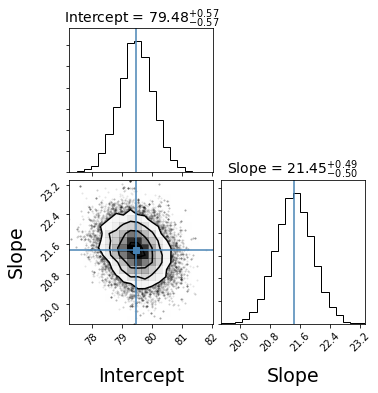

In [20]:
#corner plot
fig_corner= corner.corner(mc_result.flatchain, 
                  labels=['Intercept', 'Slope'], 
                  truths=list(mc_result.params.valuesdict().values()), 
                  label_kwargs={"fontsize": 19}, hist2d_kwargs={"fontsize": 13},
                  title_kwargs={"fontsize": 14},
                  show_titles=True)


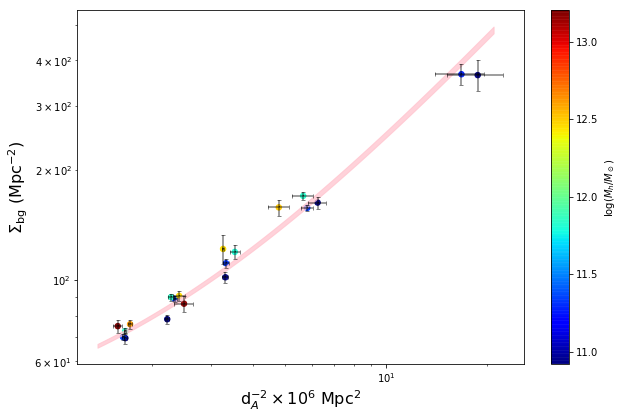

In [21]:
plt_fit_sdbg(da2_sub, eda2_sub, sd_bg, esd_bg, mh_sub, mc_result)

In [22]:
# output the chain (post burn-in) values:
from astropy.table import Column
from astropy.table import Table
from astropy.io import ascii

chain_int = Column(mc_result.flatchain['Int'],   name='Chain_Int',   dtype=float,format='%11.4f')
chain_slp = Column(mc_result.flatchain['Slope'], name='Chain_Slope', dtype=float,format='%11.4f')

tab_ochain_intslope = Table([chain_int, chain_slp])
fout_ochain_intslope = '../data/newsub_panel_pfit_chainvalues_intslope.txt'
ascii.write(tab_ochain_intslope, fout_ochain_intslope)